# Luminous Red Galaxy Target Selection & Photometric Redshift Regression Using Machine Learning Techniques

# Introduction

Luminous Red Galaxies (LRGs) are intrinsically very luminous objects that can be observed to great distance. They present themselves as excellent tracers of the large scale structure of the universe. Selecting LRGs with optical photometry becomes increasingly difficult at $z > 0.6$. Here, we present the results of machine learning techniques for selecting LRGs at redshifts $z > 0.6$ as well as predicting photometric redshift at $z > 0.3$ utilizing SDSS and WISE photometry.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control overfitting. The algorithm is implemented in \texttt{sklearn.ensemble}. 
Two parameters \texttt{n\_estimators} (the number of trees in the forest) and \texttt{max\_depth} (the maximum depth of the tree) are considered when we use \texttt{RandomForestClassifier}. \texttt{Max\_depth} is the most significant parameter for overfitting.

In this paper, I would mostly describe our work on LRG Target selection. In Section. \ref{s:data}, we briefly describe the features in our dataset, criteria for the candidates and LRGs and how errors come in the classification. In Section. \ref{s:preliminary}, we present the results from standard cuts and $r/i/z$/WISE on colors of our dataset. In Section. \ref{s:random}, we applied the random forest classification on selected features. Some trials on other machine learning classifiers and photometric redshift regression will be discussed in Section. \ref{s:other} and \ref{s:photo} respectively.

# Dataset and features

Our dataset is from SDSS and WISE provided by Prof. Jeffery Newman.

In [13]:
import numpy as np
from astropy.table import Table
import classifiers

# Machine Learning Kit:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

#Cross-Validation:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [14]:
#Reads FITS file provided by Prof. Newman:
data = Table.read('test_catalog.fits')

#Prints data read above:
data

RA,DEC,OBJID,UB_0,Z,Z_ERR,CMODELMAG [5],CMODELMAGERR [5],MODELMAG [5],MODELMAGERR [5],PSFMAG [5],PSFMAGERR [5],EXTINCTION [5],FRACDEV,FIBERMAG [5],W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,GOODZ
float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
122.062,43.5828,1237651065724994273,1.21969,0.95757,0.000230368,20.5074 .. 18.6075,0.891139 .. 0.133395,24.0199 .. 19.6422,1.71069 .. 0.13806,23.9534 .. 20.2796,1.04534 .. 0.143497,0.276438 .. 0.0793116,1.0,24.4503 .. 20.9591,15.451,0.051,15.021,0.102,1.0
122.333,44.5576,1237651066262258444,1.35367,0.650483,7.27745e-05,26.3923 .. 19.9352,0.478465 .. 0.147489,26.4015 .. 20.0283,0.490272 .. 0.138789,26.1421 .. 20.0671,0.586988 .. 0.135788,0.203402 .. 0.0583572,1.0,25.5676 .. 20.8505,16.044,0.072,15.326,0.119,1.0
122.535,44.7521,1237651066262389029,2.1121,0.000128611,3.74651e-05,25.8632 .. 18.3611,2.82556 .. 0.0355485,25.8639 .. 18.3932,0.766053 .. 0.0324293,25.8164 .. 18.393,0.789321 .. 0.0344252,0.195897 .. 0.056204,1.0,25.319 .. 19.2126,15.459,0.051,15.271,0.128,1.0
124.648,46.6889,1237651066263437763,1.52783,0.502134,0.000261753,21.2788 .. 19.8604,1.04514 .. 0.120513,23.912 .. 19.8119,1.09938 .. 0.126602,24.1445 .. 20.0845,0.974601 .. 0.118274,0.226533 .. 0.0649936,1.0,24.6087 .. 20.7103,16.283,0.087,15.927,0.21,1.0
122.22,45.1576,1237651066799325694,1.86672,0.549403,0.000150853,23.212 .. 19.6258,1.15574 .. 0.112137,23.1195 .. 19.2345,1.03086 .. 0.115465,23.0063 .. 19.9182,0.582838 .. 0.113701,0.223555 .. 0.0641392,0.0,23.5928 .. 20.5545,15.597,0.053,15.654,0.17,1.0
123.816,46.6368,1237651066800112332,1.485,0.59043,0.000291942,23.4803 .. 19.3171,0.777078 .. 0.112531,22.8455 .. 18.7959,1.16212 .. 0.116088,23.3826 .. 19.9338,0.70802 .. 0.111098,0.260485 .. 0.0747347,1.0,23.9788 .. 20.6928,15.485,0.05,15.293,0.125,1.0
122.581,43.7244,1237651190279897692,3.52008,0.631633,0.000172079,25.3826 .. 19.5906,3.08948 .. 0.127354,25.491 .. 19.7647,0.911947 .. 0.114736,25.3819 .. 20.3697,0.637377 .. 0.137793,0.343594 .. 0.0985792,0.649568,24.2009 .. 20.6856,15.258,0.045,15.029,0.095,1.0
122.998,44.1335,1237651190280094530,1.39423,0.50333,0.000288563,25.0858 .. 19.3712,0.972063 .. 0.16482,26.1739 .. 19.8382,0.742423 .. 0.164539,24.9385 .. 20.7432,0.780142 .. 0.161638,0.264939 .. 0.0760125,1.0,24.9766 .. 21.2613,16.154,0.076,16.377,0.286,1.0
123.02,44.1352,1237651190280094546,1.29743,-0.000127221,8.82959e-05,21.2812 .. 19.8657,0.938554 .. 0.0831822,24.9183 .. 19.887,0.808859 .. 0.0826965,24.7761 .. 19.9021,0.807923 .. 0.0791454,0.266679 .. 0.0765119,1.0,24.5744 .. 20.6513,16.957,0.145,16.304,-9999.0,1.0


The features we used are Z (redshift), Z ERR (redshift error), UB 0, CMODEL/MODEL/PSF MAG and the corresponding errors in u, g, r, i, z bands, EXTINCTION, W1 and W2 MAG and errors, FRACDEV and GOODZ (1 if redshift is reliable, 0 if not). Since LRSs use both SDSS and WISE photometry, we are limited to the objects which are reli- ably detected in SDSS and WISE. By investigating the flat numbers among features, we apply the following limits over the entire sample:

$$ 0 < \mathtt{Z\_ERR} < 0.01\;\; (\sigma_{\mathtt{W2}} > 0) $$

Where $\sigma_{\mathtt{W2}} > 0$ depends on whether W2 magnitudes are considered. Besides the criterion above, LRGs are identified based on the following criteria:
$$ \mathtt{UB_0} > 1, \mathtt{GOODZ} = 1, \texttt{Z} > 0.6 $$
Below is the code for Table 1 in the paper.

In [17]:
# Some statistics about dataset

redshift = data['Z']
redshifterr = data['Z_ERR']
U_B = data['UB_0']
goodz = data['GOODZ']
fracdev = data['FRACDEV']

# good LRGs # = 4946 (goodz = 1, z > 0.6, U_B > 1, w2_err > 0, 0 < z_err < 0.01) with W2 detected
y0 = np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(goodz == 1, redshift > 0.6), U_B > 1), data['W2SIGMPRO'] > 0), redshifterr<0.01), redshifterr>0).astype('int')
# good LRGs # = 5122 (goodz = 1, z > 0.6, U_B > 1, 0 < z_err < 0.01) without W2 detected
y = np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(goodz == 1, redshift > 0.6), U_B > 1), 1), redshifterr<0.01), redshifterr>0).astype('int')

# good data candidates # = 12292 (w2_err > 0, 0 < z_err < 0.01) with W2 detected
s0 = np.logical_and(data['W2SIGMPRO'] > 0, np.logical_and(redshifterr<0.01, redshifterr>0)).astype('int')
# good data candidates # = 12836 (0 < z_err < 0.01) without W2 detected
s = np.logical_and(1, np.logical_and(redshifterr<0.01, redshifterr>0)).astype('int')

print 'total # data =', y0.shape[0]
print 'good data candidates (with W2 detected) # =', np.sum(s0)
print 'good data candidates (without W2 detected) # =', np.sum(s)
print 'good LRGs (with W2 detected) # =', np.sum(y0)
print 'good LRGs (without W2 detected) # =', np.sum(y)

total # data = 12959
good data candidates (with W2 detected) # = 12292
good data candidates (without W2 detected) # = 12836
good LRGs (with W2 detected) # = 4946
good LRGs (without W2 detected) # = 5122


We firstly subtract extinction from magnitudes we use. All magnitudes come with errors. To take errors into consideration, we add Gaussian noise drawn from the predicted errors for a certain number of iteration in each band on the magnitudes we use. The size of dataset would be enlarged based on the repeated production with errors.

In [18]:
# Load Features of modelmag (requires a detection in W2)

modelmag0 = np.column_stack((data['MODELMAG'] - data['EXTINCTION'], data['W1MPRO'], data['W2MPRO']))[s0 == 1, :]
modelmagerr0 = np.column_stack((data['MODELMAGERR'], data['W1SIGMPRO'], data['W2SIGMPRO']))[s0 == 1, :]

ntotal0 = np.sum(s0 == 1)

# Parameter for the incorporation of Gaussian noise:
nrepeats0 = int(4)

modelmaglong0 = np.repeat(modelmag0, nrepeats0, axis=0)
modelmagerrlong0 = np.repeat(modelmagerr0, nrepeats0, axis=0)

# We now finally proceed to incorporate the Gaussian noise into the data. The final result is stored in the 'modelmagn' array
# defined below. Notice that 'modelmagn' has 8 axes - each one for a given filter (u,g,r,i,z,w1,w2).
modelmagn0 = np.zeros((nrepeats0*ntotal0, 7))
# Adding Gaussian noise with variance 'Z_ERR' to the selected objects:
modelmagn0 = modelmaglong0 + modelmagerrlong0*np.random.randn(nrepeats0*ntotal0, 7)

fracdevn0 = np.repeat(fracdev[s0 == 1], nrepeats0, axis=0)

We define two estimators on LRG selection. The first one is accuracy showing the fraction of objects that are well-classified. The other one, which we are more interested in, is called in-bag score showing the fraction of objects classified as LRGs that are in fact LRGs.

In [21]:
# Test the importance for each feature (u,g,r,i,z,w1,w2,fracdev)
# Using params n_estimators = 20, max_depth=10

XCn0 = np.column_stack((modelmagn0, fracdevn0))
LRGn0 = np.repeat(y[s0 == 1], nrepeats0, axis=0)

clsn = RandomForestClassifier(n_estimators = 20, max_depth=10)
clsn.fit(XCn0, LRGn0)
print "Accuracy = ", clsn.score(XCn0, LRGn0)
print "In-bag score = ", np.sum(np.logical_and(clsn.predict(XCn0),LRGn0))*1./np.sum(clsn.predict(XCn0))
print "These numbers show a normalized importance of each feature:\n", clsn.feature_importances_

Accuracy =  0.794541164985
In-bag score =  0.782208231316
These numbers show a normalized importance of each feature:
[ 0.08493475  0.20332766  0.23959344  0.11872517  0.08660755  0.17560345
  0.05454422  0.03666376]


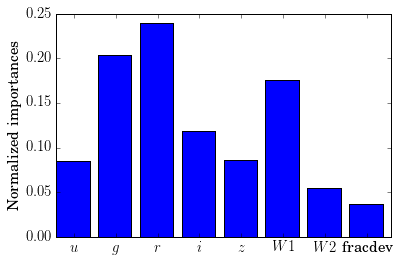

In [22]:
# To plot the normalized importance in a bar gram
plt.figure(1)
ind = np.arange(8)
width = 0.85
plt.bar(ind, clsn.feature_importances_)
plt.xticks(ind+width/2., ('$u$', '$g$', '$r$', '$i$', '$z$', '$W1$', '$W2$', r'\textrm{fracdev}'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'\textrm{Normalized importances}', fontsize=15)

[ 0.06617196  0.12129209  0.20661144  0.18874842  0.09499833  0.21980076
  0.06152501  0.04085197]


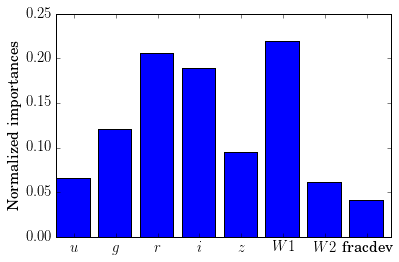

In [38]:
# Compare importance in cmodelmag

# Load Features of cmodelmag (requires a detection in W2)

cmodelmag0 = np.column_stack((data['CMODELMAG'] - data['EXTINCTION'], data['W1MPRO'], data['W2MPRO']))[s0 == 1, :]
cmodelmagerr0 = np.column_stack((data['CMODELMAGERR'], data['W1SIGMPRO'], data['W2SIGMPRO']))[s0 == 1, :]

cmodelmaglong0 = np.repeat(cmodelmag0, nrepeats0, axis=0)
cmodelmagerrlong0 = np.repeat(cmodelmagerr0, nrepeats0, axis=0)

# (u,g,r,i,z,w1,w2)
cmodelmagn0 = np.zeros((nrepeats0*ntotal0, 7))

cmodelmagn0 = cmodelmaglong0 + cmodelmagerrlong0*np.random.randn(nrepeats0*ntotal0, 7)

cXCn0 = np.column_stack((cmodelmagn0,fracdevn0))
cLRGn0 = np.repeat(y[s0 == 1], nrepeats0, axis=0)

clsn = RandomForestClassifier(n_estimators = 20,max_depth=10)
clsn.fit(cXCn0, cLRGn0)
print clsn.feature_importances_

plt.figure(1)
ind = np.arange(8)
width = 0.85
plt.bar(ind, clsn.feature_importances_)
plt.xticks(ind+width/2., ('$u$', '$g$', '$r$', '$i$', '$z$', '$W1$', '$W2$', r'\textrm{fracdev}'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'\textrm{Normalized importances}', fontsize=15)

[ 0.04549475  0.23109845  0.29382003  0.13823651  0.09491026  0.13079634
  0.04618845  0.01945521]


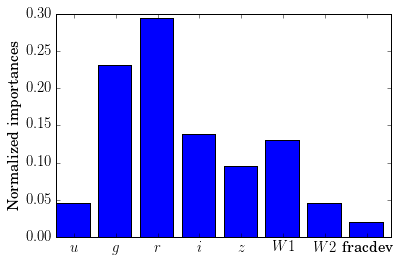

In [8]:
# Compare importance in psfmag

# Load Features of cmodelmag (requires a detection in W2)

psfmag0 = np.column_stack((data['PSFMAG'] - data['EXTINCTION'], data['W1MPRO'], data['W2MPRO']))[s0 == 1, :]
psfmagerr0 = np.column_stack((data['PSFMAGERR'], data['W1SIGMPRO'], data['W2SIGMPRO']))[s0 == 1, :]

psfmaglong0 = np.repeat(psfmag0, nrepeats0, axis=0)
psfmagerrlong0 = np.repeat(psfmagerr0, nrepeats0, axis=0)

# (u,g,r,i,z,w1,w2)
psfmagn0 = np.zeros((nrepeats0*ntotal0, 7))

psfmagn0 = psfmaglong0 + psfmagerrlong0*np.random.randn(nrepeats0*ntotal0, 7)

pXCn0 = np.column_stack((psfmagn0,fracdevn0))
pLRGn0 = np.repeat(y[s0 == 1], nrepeats0, axis=0)

clsn = RandomForestClassifier(n_estimators = 20,max_depth=10)
clsn.fit(pXCn0, pLRGn0)
print clsn.feature_importances_

plt.figure(1)
ind = np.arange(8)
width = 0.85
plt.bar(ind, clsn.feature_importances_)
plt.xticks(ind+width/2., ('$u$', '$g$', '$r$', '$i$', '$z$', '$W1$', '$W2$', r'\textrm{fracdev}'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'\textrm{Normalized importances}', fontsize=15)

It is always better to keep fewer features for computational efficiency and physics sig- nificance. We compare importances using the attribute ‘feature importances ’ in RandomForestClassifier on colors and magnitudes. We found that W2 and FRACDEV were two least important features. As a result, we dropped W2 and FRACDEV as well as the requirement of a detection in W2 band (in parentheses in Section. 2). After several trials on different sets of features, the features (extinction-corrected) we used are
$$ r - \mathtt{W1}, r - i, i - z, i, g - i, u - g $$

In [40]:
# From the figure above, it's not bad to drop the requirement of a detection in W2 since W2 is the 2nd least improtant one.
# We also drop fracdev

# Load Features of modelmag (No requirement of a detection in W2)
zn = (data['MODELMAG'] - data['EXTINCTION'])[s==1,4]
modelmag = np.column_stack((data['MODELMAG'] - data['EXTINCTION'], data['W1MPRO'], data['W2MPRO']))[s == 1, :]
modelmagerr = np.column_stack((data['MODELMAGERR'], data['W1SIGMPRO'], data['W2SIGMPRO']))[s == 1, :]

ntotal = np.sum(s == 1)

# Parameter for the incorporation of Gaussian noise:
nrepeats = int(4)

modelmaglong = np.repeat(modelmag, nrepeats, axis=0)
modelmagerrlong = np.repeat(modelmagerr, nrepeats, axis=0)
znlong = np.repeat(zn, nrepeats, axis=0)
# We now finally proceed to incorporate the Gaussian noise into the data. The final result is stored in the 'modelmagn' array
# defined below. Notice that 'modelmagn' has 8 axes - each one for a given filter (u,g,r,i,z,w1,w2).
modelmagn = np.zeros((nrepeats*ntotal, 7))
# Adding Gaussian noise with variance 'Z_ERR' to the selected objects:
modelmagn = modelmaglong + modelmagerrlong*np.random.randn(nrepeats*ntotal, 7)

fracdevn = np.repeat(fracdev[s == 1], nrepeats, axis=0)

r_w1n = modelmagn[:,2] - modelmagn[:,5]
r_in = modelmagn[:,2] - modelmagn[:,3]
i_zn = modelmagn[:,3] - modelmagn[:,4]

fracdevn = np.repeat(fracdev[s == 1], nrepeats, axis=0)

# features we used: r-w1, r-i, i-z, i, g-i, u-g
XCn = np.column_stack((r_w1n,r_in,i_zn,modelmagn[:,3],modelmagn[:,1]-modelmagn[:,3],modelmagn[:,0]-modelmagn[:,1]))

LRGn = np.repeat(y[s == 1], nrepeats, axis=0)

In [41]:
print modelmagerrlong

[[ 1.71069288  0.50761074  0.18656239 ...,  0.13805988  0.051       0.102     ]
 [ 1.71069288  0.50761074  0.18656239 ...,  0.13805988  0.051       0.102     ]
 [ 1.71069288  0.50761074  0.18656239 ...,  0.13805988  0.051       0.102     ]
 ..., 
 [ 1.28499532  0.34084067  0.09591442 ...,  0.15293397  0.072       0.237     ]
 [ 1.28499532  0.34084067  0.09591442 ...,  0.15293397  0.072       0.237     ]
 [ 1.28499532  0.34084067  0.09591442 ...,  0.15293397  0.072       0.237     ]]


In [36]:
print "Sanity check here..."
print "Number of candidates (Number of repeat, here 4 * Number of orginal candidates) = ", XCn.shape[0]
print "Number of features = ", XCn.shape[1]
print "First LRG = ", XCn[0]

Sanity check here...
Number of candidates (Number of repeat, here 4 * Number of orginal candidates) =  51344
Number of features =  6
First LRG =  [ 13.16920468  38.62937934 -44.75460902  -9.99685073  31.33495978
  16.14472975]


In [29]:
# Cross validation. We conducted cross validation only on the parameter maxdepth since the scores/rates are most sensitive to
# it. For n_estimators, n_estimators = 20 can do a pretty job. As you increase the number of it, it may provide a slight better
# result but we just set n_estimators = 20 to save time in this part. As for the cross validation, we choose accuracy to measure
# possible overfitting.

nfolds = 10
maxdepth = np.arange(1,20)
nparams = len(maxdepth)
kf = KFold(len(LRGn), n_folds=nfolds)

scores = np.zeros((nfolds,nparams))
cvscores = np.zeros(nparams)
i = 0
for train, test in kf:
    X_train, X_test, y_train, y_test = XCn[train,:], XCn[test,:], LRGn[train], LRGn[test]
    for j in range(nparams):
        clsn = RandomForestClassifier(n_estimators = 20,max_depth=maxdepth[j])
        clsn.fit(X_train, y_train)
        scores[i,j] = clsn.score(X_test, y_test)
    i = i + 1
print scores.mean(axis=0)
# plt.plot(maxdepth,scores.mean(axis=0))
# plt.xlabel('Max depth')
# plt.ylabel('Scores')

[ 0.60092589  0.60084798  0.60096482  0.6006922   0.60036109  0.60086745
  0.60030263  0.60065326  0.59975733  0.59938734  0.59954313  0.59919257
  0.59777081  0.5979461   0.59599845  0.59416782  0.59401194  0.59237599
  0.59144112]


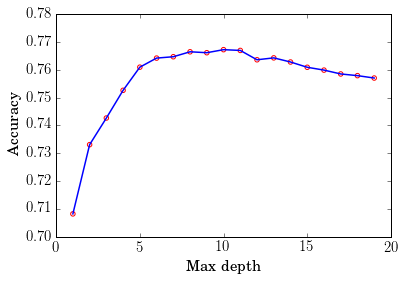

In [27]:
plt.figure(1)
plt.plot(maxdepth,scores.mean(axis=0), linewidth = 1.5)
plt.scatter(maxdepth, scores.mean(axis = 0), facecolors='none', edgecolors='red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,20)
plt.xlabel(r'\textrm{Max depth}', fontsize=15)
plt.ylabel(r'\textrm{Accuracy}', fontsize=15)

In [44]:
nfolds = 10
maxdepth = np.arange(1,20)
nparams = len(maxdepth)
kf = KFold(len(LRGn), n_folds=nfolds)

scores = np.zeros((nfolds,nparams))
cvscores = np.zeros(nparams)
i = 0
for train, test in kf:
    X_train, X_test, y_train, y_test = XCn[train,:], XCn[test,:], LRGn[train], LRGn[test]
    for j in range(nparams):
        clsn = RandomForestClassifier(n_estimators = 20,max_depth=maxdepth[j])
        clsn.fit(X_train, y_train)
        scores[i,j] = np.sum(np.logical_and(clsn.predict(X_test),y_test))*1./np.sum(clsn.predict(X_test))
    i = i + 1
print scores.mean(axis=0)

[ 0.71057386  0.68274602  0.68486945  0.6933545   0.69666259  0.70292963
  0.70759739  0.70669818  0.70677485  0.71062964  0.70865309  0.70645022
  0.7038759   0.70360588  0.70271558  0.69579561  0.69616432  0.69079259
  0.69415245]


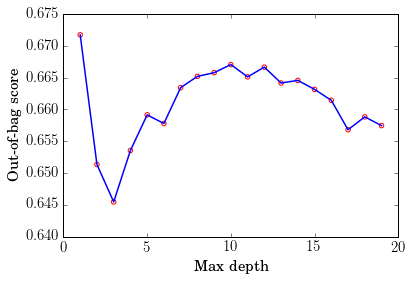

In [51]:
plt.figure(1)
plt.plot(maxdepth,scores.mean(axis=0), linewidth = 1.5)
plt.scatter(maxdepth, scores.mean(axis = 0), facecolors='none', edgecolors='red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,20)
plt.xlabel(r'\textrm{Max depth}', fontsize=15)
plt.ylabel(r'\textrm{Out-of-bag score}', fontsize=15)

Score with max depth = 10 0.791523839202
Rate with max depth = 10 0.763350559862


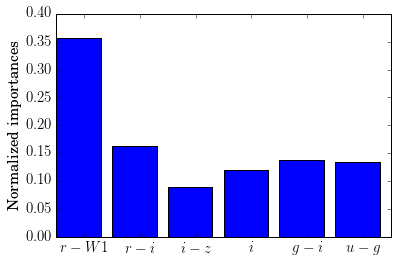

In [61]:
# You can see that the best choice is Max depth = 10 here. You can change max depth = 11 here to see the change (will change
# a lot on scores/rates)

clsn = RandomForestClassifier(n_estimators = 20, max_depth=10)
clsn.fit(XCn, LRGn)
print 'Score with max depth = 10' ,clsn.score(XCn, LRGn)
print 'Rate with max depth = 10', np.sum(np.logical_and(clsn.predict(XCn),LRGn))*1./np.sum(clsn.predict(XCn))
plt.figure(1)
ind = np.arange(6)
width = 1
plt.bar(ind, clsn.feature_importances_)
plt.xticks(ind+width/2., ('$r-W1$', '$r-i$', '$i-z$', '$i$', '$g-i$', '$u-g$'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'\textrm{Normalized importances}', fontsize=15)

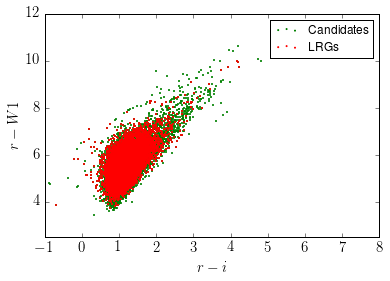

In [45]:
# Based on MODELMAG, we visualize the distributions of candidates and LRGs in a 2d space. The 2 features are chosen as 
# the most important 2 features above (i.e. r-i, r-W1). Our goal is to separate (classify) red from green dots.

plt.figure(1)
plt.scatter(r_in,r_w1n,s=1,color='g',label='Candidates')
plt.scatter(r_in[LRGn==1],r_w1n[LRGn==1],s=1,color='r',label='LRGs')
plt.xlabel('$r-i$', fontsize=15)
plt.ylabel('$r-W1$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-1,8)
plt.ylim(2.5,12)
plt.legend()

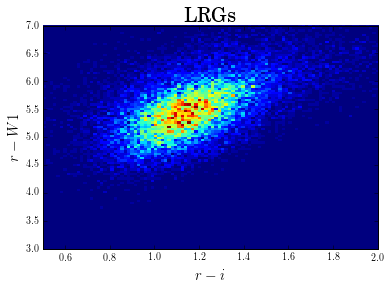

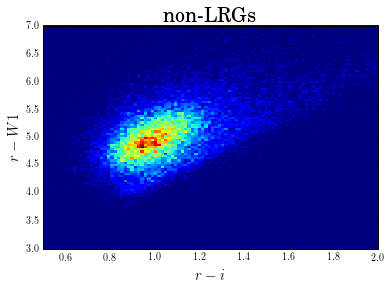

In [46]:
# We can also do 2d histograms of LRGs and non-LRGs. Though they are mostly close, there is still some differences in 
# this 2d space. Also note that with the help of other features (i.e. go into a higher dimensional space), we could 
# do a better classification.

plt.figure(1)
plt.hist2d(r_in[LRGn==1],r_w1n[LRGn==1],bins=[100,100],range=[[0.5,2],[3,7]])
plt.xlim(0.5,2)
plt.ylim(3,7)
plt.title(r'\textrm{LRGs}', fontsize=20)
plt.xlabel('$r-i$',fontsize=15)
plt.ylabel('$r-W1$',fontsize=15)

plt.figure(2)
plt.hist2d(r_in[LRGn==0],r_w1n[LRGn==0],bins=[100,100],range=[[0.5,2],[3,7]])
plt.xlim(0.5,2)
plt.ylim(3,7)
plt.title(r'\textrm{non-LRGs}', fontsize=20)
plt.xlabel('$r-i$',fontsize=15)
plt.ylabel('$r-W1$',fontsize=15)

0.729257556871


(2.5, 12)

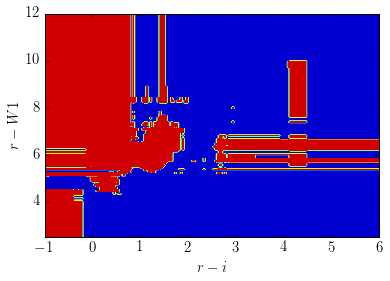

In [51]:
# Plot the decision boundary of Random forests. It might be a little nasty but it can do a better job.

X = np.column_stack((r_in,r_w1n))
clf = RandomForestClassifier(n_estimators=20,max_depth=9)
clf.fit(X,LRGn)
print clf.score(X,LRGn)

plot_step = 0.04

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.jet)
plt.xlabel('$r-i$', fontsize=15)
plt.ylabel('$r-W1$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-1,6)
plt.ylim(2.5,12)

(2.5, 12)

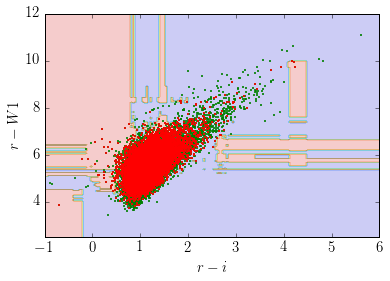

In [52]:
# A clear view of the decision boundary along with the data
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.jet,alpha=0.2)
plt.scatter(r_in,r_w1n,s=1,color='g')
plt.scatter(r_in[LRGn==1],r_w1n[LRGn==1],s=1,color='r')
plt.xlabel('$r-i$', fontsize=15)
plt.ylabel('$r-W1$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-1,6)
plt.ylim(2.5,12)

In [57]:
# Table 2. -- Accuracy and in-bag scores of the standard cuts (Maybe a little bit different due to the random noise)

LRGt = np.logical_and(r_in>0.98,(r_w1n-2.683)>2*r_in)
print "Accuracy = ", np.sum(LRGtn==LRGn)*1./len(LRGn)
print "In-bag score = ", np.sum(np.logical_and(LRGtn,LRGn))*1./np.sum(LRGtn)

Accuracy =  0.64036693674
In-bag score =  0.6065073181


In [56]:
# Table 2. -- Accuracy and in-bag scores of the u cuts (Maybe a little bit different due to the random noise)
LRGtn = np.logical_and(np.logical_and(np.logical_and(r_in>0.98,(r_w1n-2.683)>2*r_in),i_zn>0.625),znlong<=19.95)
print "Accuracy = ", np.sum(LRGtn==LRGn)*1./len(LRGn)
print "In-bag score = ", np.sum(np.logical_and(LRGtn,LRGn))*1./np.sum(LRGtn)

0.64036693674
0.6065073181


(2.5, 12)

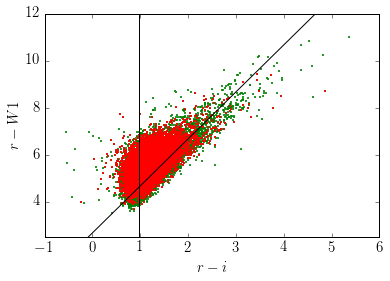

In [133]:
plt.scatter(r_in,r_w1n,s=1,color='g')
plt.scatter(r_in[LRGn==1],r_w1n[LRGn==1],s=1,color='r')
xp = np.linspace(-1,6,100)
plt.plot(xp,2*xp+2.683,'k-')
plt.axvline(x=0.98,color='k')
plt.xlabel('$r-i$', fontsize=15)
plt.ylabel('$r-W1$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-1,6)
plt.ylim(2.5,12)

In [47]:
# Load Features of cmodelmag (No requirement of a detection in W2). We did the similar test and found W2 and fracdev were least
# important.

cmodelmag = np.column_stack((data['CMODELMAG'] - data['EXTINCTION'], data['W1MPRO'], data['W2MPRO']))[s == 1, :]
cmodelmagerr = np.column_stack((data['CMODELMAGERR'], data['W1SIGMPRO'], data['W2SIGMPRO']))[s == 1, :]

ntotal = np.sum(s == 1)

# Parameter for the incorporation of Gaussian noise:
nrepeats = int(4)

cmodelmaglong = np.repeat(cmodelmag, nrepeats, axis=0)
cmodelmagerrlong = np.repeat(cmodelmagerr, nrepeats, axis=0)

# We now finally proceed to incorporate the Gaussian noise into the data. The final result is stored in the 'modelmagn' array
# defined below. Notice that 'modelmagn' has 8 axes - each one for a given filter (u,g,r,i,z,w1,w2).
cmodelmagn = np.zeros((nrepeats*ntotal, 7))
# Adding Gaussian noise with variance 'Z_ERR' to the selected objects:
cmodelmagn = cmodelmaglong + cmodelmagerrlong*np.random.randn(nrepeats*ntotal, 7)


cr_w1n = cmodelmagn[:,2] - cmodelmagn[:,5]
cr_in = cmodelmagn[:,2] - cmodelmagn[:,3]
ci_zn = cmodelmagn[:,3] - cmodelmagn[:,4]

# features we used: cr-w1, cr-i, ci-z, ci, cg-i, cu-g

cXCn = np.column_stack((cr_w1n,cr_in,ci_zn,cmodelmagn[:,3],cmodelmagn[:,1]-cmodelmagn[:,3],cmodelmagn[:,0]-cmodelmagn[:,1]))
cLRGn = np.repeat(y[s == 1], nrepeats, axis=0)

In [48]:
nfolds = 10
maxdepth = np.arange(1,20)
nparams = len(maxdepth)
kf = KFold(len(cLRGn), n_folds=nfolds)

scores = np.zeros((nfolds,nparams))
cvscores = np.zeros(nparams)
i = 0
for train, test in kf:
    X_train, X_test, y_train, y_test = cXCn[train,:], cXCn[test,:], cLRGn[train], cLRGn[test]
    for j in range(nparams):
        clsn = RandomForestClassifier(n_estimators = 20,max_depth=maxdepth[j])
        clsn.fit(X_train, y_train)
        scores[i,j] = clsn.score(X_test, y_test)
    i = i + 1
print scores.mean(axis=0)
# plt.plot(maxdepth,scores.mean(axis=0))
# plt.xlabel('Max depth')
# plt.ylabel('Scores')

[ 0.65043438  0.6949785   0.70609984  0.7122738   0.72010346  0.72341465
  0.72664773  0.72855635  0.72773821  0.73081564  0.7306597   0.73155553
  0.7289652   0.72896515  0.72767982  0.72606322  0.7231418   0.72267436
  0.72162255]


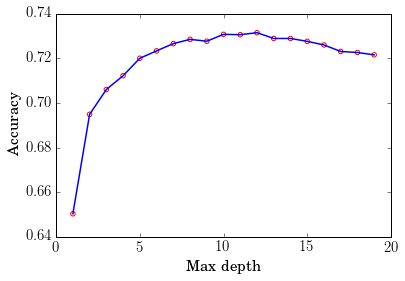

In [49]:
plt.figure(1)
plt.plot(maxdepth,scores.mean(axis=0), linewidth = 1.5)
plt.scatter(maxdepth, scores.mean(axis = 0), facecolors='none', edgecolors='red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,20)
plt.xlabel(r'\textrm{Max depth}', fontsize=15)
plt.ylabel(r'\textrm{Accuracy}', fontsize=15)

In [50]:
nfolds = 10
maxdepth = np.arange(1,20)
nparams = len(maxdepth)
kf = KFold(len(cLRGn), n_folds=nfolds)

scores = np.zeros((nfolds,nparams))
cvscores = np.zeros(nparams)
i = 0
for train, test in kf:
    X_train, X_test, y_train, y_test = cXCn[train,:], cXCn[test,:], cLRGn[train], cLRGn[test]
    for j in range(nparams):
        clsn = RandomForestClassifier(n_estimators = 20,max_depth=maxdepth[j])
        clsn.fit(X_train, y_train)
        scores[i,j] = np.sum(np.logical_and(clsn.predict(X_test),y_test))*1./np.sum(clsn.predict(X_test))
    i = i + 1
print scores.mean(axis=0)
# plt.plot(maxdepth,scores.mean(axis=0))
# plt.xlabel('Max depth')
# plt.ylabel('Scores')

[ 0.6717171   0.65137702  0.64551367  0.65357377  0.6591561   0.65780499
  0.66342375  0.66519667  0.6657714   0.66704593  0.66511657  0.66664608
  0.66415603  0.6645642   0.66315498  0.66144203  0.65682361  0.65884749
  0.65747604]


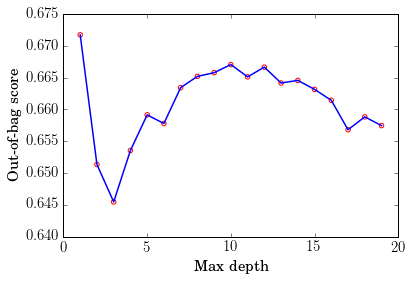

In [52]:
plt.figure(1)
plt.plot(maxdepth,scores.mean(axis=0), linewidth = 1.5)
plt.scatter(maxdepth, scores.mean(axis = 0), facecolors='none', edgecolors='red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,20)
plt.xlabel(r'\textrm{Max depth}', fontsize=15)
plt.ylabel(r'\textrm{Out-of-bag score}', fontsize=15)

Score with max depth = 10 0.784609691493
Rate with max depth = 10 0.738358865463


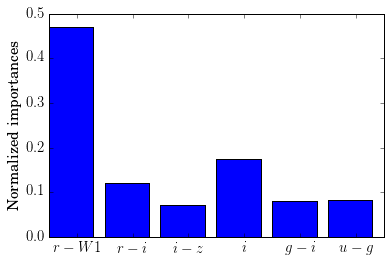

In [53]:
# You can see that the best choice is Max depth = 10 here. You can change max depth = 11 here to see the change (will change
# a lot on scores/rates)

clsn = RandomForestClassifier(n_estimators = 20, max_depth=10)
clsn.fit(cXCn, cLRGn)
print 'Score with max depth = 10' ,clsn.score(cXCn, cLRGn)
print 'Rate with max depth = 10', np.sum(np.logical_and(clsn.predict(cXCn),cLRGn))*1./np.sum(clsn.predict(cXCn))
plt.figure(1)
ind = np.arange(6)
width = 1
plt.bar(ind, clsn.feature_importances_)
plt.xticks(ind+width/2., ('$r-W1$', '$r-i$', '$i-z$', '$i$', '$g-i$', '$u-g$'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'\textrm{Normalized importances}', fontsize=15)

In [54]:
# Load Features of cmodelmag (No requirement of a detection in W2). We did the similar test and found W2 and fracdev were least
# important.

psfmag = np.column_stack((data['PSFMAG'] - data['EXTINCTION'], data['W1MPRO'], data['W2MPRO']))[s == 1, :]
psfmagerr = np.column_stack((data['PSFMAGERR'], data['W1SIGMPRO'], data['W2SIGMPRO']))[s == 1, :]

ntotal = np.sum(s == 1)

# Parameter for the incorporation of Gaussian noise:
nrepeats = int(4)

psfmaglong = np.repeat(psfmag, nrepeats, axis=0)
psfmagerrlong = np.repeat(psfmagerr, nrepeats, axis=0)

# We now finally proceed to incorporate the Gaussian noise into the data. The final result is stored in the 'modelmagn' array
# defined below. Notice that 'modelmagn' has 8 axes - each one for a given filter (u,g,r,i,z,w1,w2).
psfmagn = np.zeros((nrepeats*ntotal, 7))
# Adding Gaussian noise with variance 'Z_ERR' to the selected objects:
psfmagn = psfmaglong + psfmagerrlong*np.random.randn(nrepeats*ntotal, 7)


pr_w1n = psfmagn[:,2] - psfmagn[:,5]
pr_in = psfmagn[:,2] - psfmagn[:,3]
pi_zn = psfmagn[:,3] - psfmagn[:,4]

# features we used: pr-w1, pr-i, pi-z, pi, pg-i, pu-g

pXCn = np.column_stack((pr_w1n,pr_in,pi_zn,psfmagn[:,3],psfmagn[:,1]-psfmagn[:,3],psfmagn[:,0]-psfmagn[:,1]))
pLRGn = np.repeat(y[s == 1], nrepeats, axis=0)

In [55]:
nfolds = 10
maxdepth = np.arange(1,20)
nparams = len(maxdepth)
kf = KFold(len(pLRGn), n_folds=nfolds)

scores = np.zeros((nfolds,nparams))
cvscores = np.zeros(nparams)
i = 0
for train, test in kf:
    X_train, X_test, y_train, y_test = pXCn[train,:], pXCn[test,:], pLRGn[train], pLRGn[test]
    for j in range(nparams):
        clsn = RandomForestClassifier(n_estimators = 20,max_depth=maxdepth[j])
        clsn.fit(X_train, y_train)
        scores[i,j] = clsn.score(X_test, y_test)
    i = i + 1
print scores.mean(axis=0)
# plt.plot(maxdepth,scores.mean(axis=0))
# plt.xlabel('Max depth')
# plt.ylabel('Scores')

[ 0.70884547  0.73437949  0.74795481  0.75675812  0.76302968  0.76612646
  0.7676262   0.76941809  0.76875572  0.76852209  0.76854171  0.76865848
  0.76678868  0.76591243  0.7641205   0.76285439  0.76458788  0.76047817
  0.75942651]


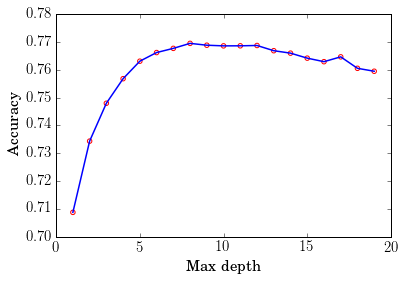

In [56]:
plt.figure(1)
plt.plot(maxdepth,scores.mean(axis=0), linewidth = 1.5)
plt.scatter(maxdepth, scores.mean(axis = 0), facecolors='none', edgecolors='red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,20)
plt.xlabel(r'\textrm{Max depth}', fontsize=15)
plt.ylabel(r'\textrm{Accuracy}', fontsize=15)

In [57]:
nfolds = 10
maxdepth = np.arange(1,20)
nparams = len(maxdepth)
kf = KFold(len(pLRGn), n_folds=nfolds)

scores = np.zeros((nfolds,nparams))
cvscores = np.zeros(nparams)
i = 0
for train, test in kf:
    X_train, X_test, y_train, y_test = pXCn[train,:], pXCn[test,:], pLRGn[train], pLRGn[test]
    for j in range(nparams):
        clsn = RandomForestClassifier(n_estimators = 20,max_depth=maxdepth[j])
        clsn.fit(X_train, y_train)
        scores[i,j] = np.sum(np.logical_and(clsn.predict(X_test),y_test))*1./np.sum(clsn.predict(X_test))
    i = i + 1
print scores.mean(axis=0)

[ 0.721479    0.67957909  0.69749342  0.71020421  0.71293396  0.71562431
  0.71762532  0.71960779  0.72209091  0.7201291   0.72131041  0.71865475
  0.71549024  0.71546763  0.71306041  0.71069503  0.71079646  0.70923351
  0.70601732]


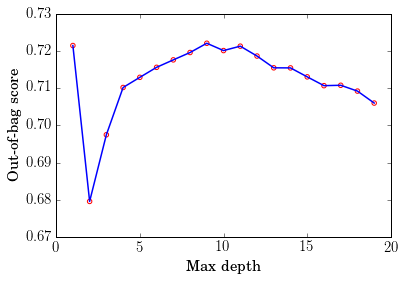

In [58]:
plt.figure(1)
plt.plot(maxdepth,scores.mean(axis=0), linewidth = 1.5)
plt.scatter(maxdepth, scores.mean(axis = 0), facecolors='none', edgecolors='red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,20)
plt.xlabel(r'\textrm{Max depth}', fontsize=15)
plt.ylabel(r'\textrm{Out-of-bag score}', fontsize=15)

Score with max depth = 10 0.805488469928
Rate with max depth = 10 0.764895817567


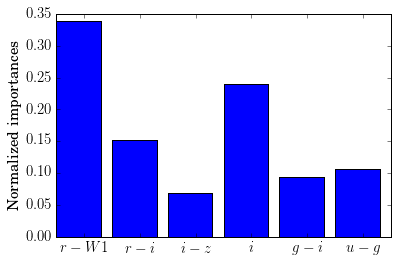

In [59]:
# You can see that the best choice is Max depth = 10 here. You can change max depth = 11 here to see the change (will change
# a lot on scores/rates)

clsn = RandomForestClassifier(n_estimators = 20, max_depth=10)
clsn.fit(pXCn, pLRGn)
print 'Score with max depth = 10' ,clsn.score(pXCn, pLRGn)
print 'Rate with max depth = 10', np.sum(np.logical_and(clsn.predict(pXCn),pLRGn))*1./np.sum(clsn.predict(pXCn))
plt.figure(1)
ind = np.arange(6)
width = 1
plt.bar(ind, clsn.feature_importances_)
plt.xticks(ind+width/2., ('$r-W1$', '$r-i$', '$i-z$', '$i$', '$g-i$', '$u-g$'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'\textrm{Normalized importances}', fontsize=15)